# Gravity Simulation:

This notebook focuses on the visualization of Potential field caused by planetary bodies.

In [145]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import cv2
import os

The below function is to find the distance between other bodies. and calculate the next position and velocites.

In [146]:
#Main function :
# X0 -> X1
# @vectorize(['float32(float32, float32, float32, float32, float32, float32)'], target='cuda')
def step(mass:'arr', x0:'arr',y0:'arr',vx0:'arr',vy0: 'arr',dt=0.1, G = 1):
    
    x1 = x0 + vx0*dt
    y1 = y0 +vy0*dt
    
    vx1 = []
    vy1 = []
    #Loop over planets to find the distance:
    for i in range(len(x1)):
        x1self = x1[i]
        y1self = y1[i]
        ax = 0
        ay = 0
        for j in range(len(x0)):
            if i == j:
                continue
            x_dist = x1[j] - x1self
            y_dist = y1[j] - y1self
            Rsq = x_dist**2 + y_dist**2

            # Contribution from the jth mass:
            a = G*mass[j]/Rsq
            ax += a * x_dist/np.sqrt(Rsq)
            ay += a * y_dist/np.sqrt(Rsq)
        vx1.append(vx0[i] + ax*dt)
        vy1.append(vy0[i] + ay*dt)
        
    return x1,y1,np.array(vx1),np.array(vy1)

#### Description( of *above function*):

The `step()` function will take the "*initial positions/previous positions*" of the bodies as inputs and give their respective "*present positions*". This is done in the following way:
1) The function `step()` takes:
- `mass` (*masses of all the bodies in one array*)
- `x0` (*x position of all the bodies in one array*)
- `y0` (*y position of all the bodies in one array*)
- `vx0` (*x component of velocties for all the bodies, also in an array*)
- `vy0` (*y component of velocties for all the bodies, also in an array*)
- `dt` (*component of time*)
- `G` (*Gravitational Constant (for visualization purposes <u>G=1</u>*)

2) Find the latest x and y positions, denoted as x1, y1:
- This is done by using the kinematic equation: $x = x_0 + v_{x_0}t$ <br> $x_0 = $ initial x_position (= `x0`). <br>$v_{x_0}$ = initial x component of velocity (= `vx0`) <br> Similarly for *y1*. <br> We proceed to make **two empty lists** for "Velocities" that we shall update within the loop.

3) We make a loop to calculate the acceleration and update the velocities. This process loops over the number of bodies and finding their acceleration using <br>the Newton's Gravitation formula: $ F = ma = \frac{G*M*m}{R^2}$. <br> After this, we find the component of acceleration $a_x, a_y$ .<br> Then we append (*add*) $v_{x_1} = v_{x_0} + a_x*dt$ to the `vx1 =[]` list (similarly for vy1).

### A function to increase the size of the masses in the plot based on the magnitude.

In [147]:
# Function to scale masses for their sizes
def scale_the_array(arr, min_=7, max_=300):
    l = []
    for element in arr:
        if arr.max() != arr.min():
            scaled_element = ((element - arr.min())/(arr.max()-arr.min()))*(max_-min_) + min_
            l.append(scaled_element)
        else:
            # Default size
            l = [20, 20]
            
    return np.array(l)

## First simulation:
1 star and two planets:

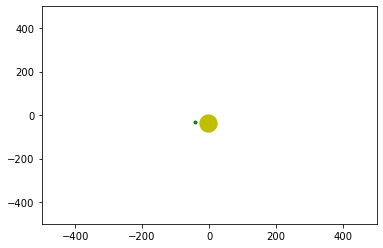

frame: 299/300


In [148]:
# masses
masses = np.array([100000, 950, 500])

# Initial x positions
x0 = np.array([0,72, 200])
# Initial y positions
y0 = np.array([0, 0, 0])
# Initial  
vx0 = np.array([0, 0, -5])
vy0 = np.array([0, -30, 12])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 


for time in range(300):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.5)
    plt.scatter(x1[0],y1[0],c='y', s= scaled_masses[0])
    plt.scatter(x1[1],y1[1], c='g', s= scaled_masses[1])
    plt.scatter(x1[2], y1[2], c='c', s = scaled_masses[2])
    plt.xlim(-500, 500)
    plt.ylim(-500, 500)
    #plt.savefig(f"../IAPT Course Work/Animations/{time+1}.png")
    plt.show()
    print(f"frame: {time}/300")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1


# Contour plot of potential

We will take a mesh grid, for each point (x, y) in the graph calculate the relative position of the bodies and find the **Potential $\large = \frac{-GMm}{R}$**, I have considered `m` to be at the end of the `masses` array (`m` *= dummy mass alocated to every point in the plot.*)

Plotting the potential graph for one body.

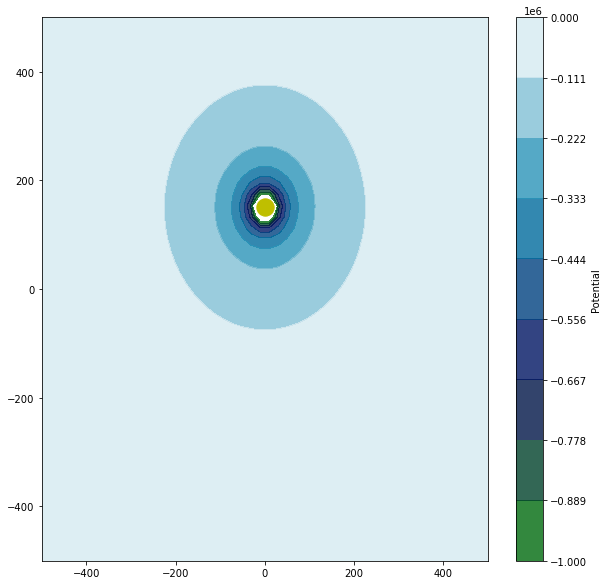

frame: 29/300


In [163]:
# masses
# dummy_mass
masses = np.array([1000000,50]) # last mass is dummy mass

# Initial x positions
x0 = np.array([0])
# Initial y positions
y0 = np.array([0])

# Initial velocities
vx0 = np.array([0])
vy0 = np.array([10])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses)

# for 300 frames update the positions and velocities
for time in range(300):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.5)
    plt.figure(figsize=(10,10))
    
    
    # Make a grid:
    # Measure the potential between each point of the grid and the object
    xx,yy = np.meshgrid(np.linspace(-500,500), np.linspace(-500,500))
    coords = []
    # this will work only if xx and yy have the same dims
    for i in range(len(xx.ravel())):
        coords.append([xx.ravel()[i],yy.ravel()[i]])    
    #coords = np.array(coords) # shape = (len(xx), 2)
    # for each coordinate in coords measure the R and find the potential:
    PE = []
    for coordinate in coords:
        # coordinate = [x_i, y_i]
        R = np.sqrt((x1[0]-coordinate[0])**2+(y1[0]-coordinate[1])**2)
        PE.append(-0.5*masses[0]*masses[-1]/R)
    # reshape PE to be of the shape of xx and yy  
    PE = np.array(PE).reshape(xx.shape)
    
    # Contour plot the potential
    plt.contourf(xx,yy,PE,
                 cmap=plt.cm.ocean, 
                 alpha=0.8,
                 levels=np.linspace(-1e6,0,10), 
                 vmin=-1e6,vmax=0)
    # levels, vmax and vmin are from trial and error.
    plt.colorbar(label='Potential')
    
    # scatter plot the body
    plt.scatter(x1[0],y1[0],c='y', s= scaled_masses[0])
    
    plt.xlim(-500, 500)
    plt.ylim(-500, 500)

    plt.show()
    print(f"frame: {time}/300")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1


## Plotting the potential graph for multiple bodies

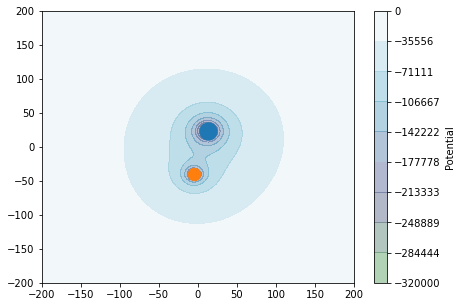

frame: 6/300


In [184]:
# Range of the mesh:
_range = (-200,200)
density_of_mesh = 100 # number of points in the mesh

# masses
masses = np.array([100090,50000,50]) # the last one is the dummy mass to find the potential

# Initial x positions
x0 = np.array([0,20])
# Initial y positions
y0 = np.array([0,0])
# Initial  
vx0 = np.array([0,0])
vy0 = np.array([0,20])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 

xx,yy = np.meshgrid(np.linspace(_range[0],_range[1],density_of_mesh), np.linspace(_range[0],_range[1], density_of_mesh))
coords = []
# this will work only if xx and yy have the same dims
for i in range(len(xx.ravel())):
    coords.append([xx.ravel()[i],yy.ravel()[i]])    
#coords = np.array(coords) # shape = (len(xx), 2)

for time in range(300):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.05)
    plt.figure(figsize=(7,5))
    
    # Make a grid:
    # Measure the potential between each point of the grid and the star
    
    # for each coordinate in coords measure the R and find the potential:
    PE = []
    for coordinate in coords:
        # coordinate = [x_i, y_i]
        # for each mass calculate the R & potential:
        pe = 0
        for body in range(len(x1)):
            # calculate R:
            R = np.sqrt((x1[body]-coordinate[0])**2+(y1[body]-coordinate[1])**2)
            
            # Using the dummy mass (located at the end of the mass array)
            pe += -0.5*masses[body]*masses[-1]/R
        PE.append(pe)
    # reshape PE to be of the shape of xx and yy  
    PE = np.array(PE).reshape(xx.shape)
    
    plt.contourf(xx, yy, PE, cmap=plt.cm.ocean, alpha=0.3, levels=np.linspace(-32e4,0,10),vmin=-32e4, vmax=0)
    plt.colorbar(label='Potential')
    for i in range(len(x0)):
        plt.scatter(x1[i], y1[i], s= scaled_masses[i])
    plt.xlim(_range[0], _range[1])
    plt.ylim(_range[0], _range[1])
    plt.show()
    print(f"frame: {time}/300")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1


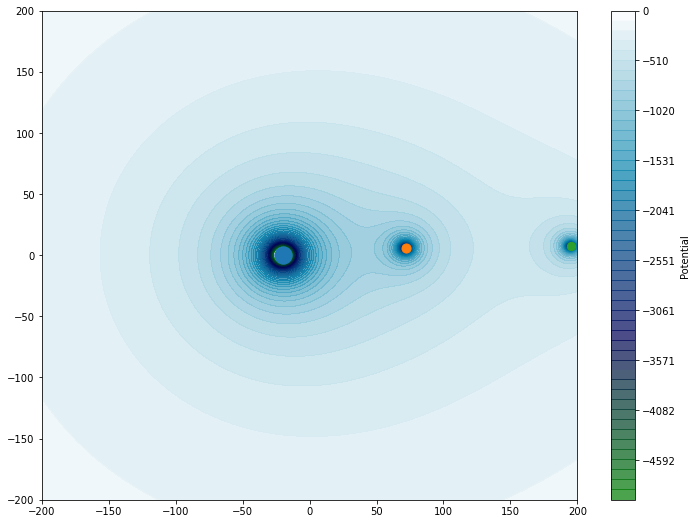

frame: 9/10


In [185]:
max_time = 1000
_range = (-200,200)
density_of_mesh = 200
# masses
masses = np.array([19000,5000,4000,3.55])
x0 = np.array([-20, 72, 200])
y0 = np.array([0, 0, 0])
vx0 = np.array([0, 0, -10])
vy0 = np.array([0, 12, 15])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 

xx,yy = np.meshgrid(np.linspace(_range[0],_range[1],density_of_mesh), np.linspace(_range[0],_range[1], density_of_mesh))
coords = []
# this will work only if xx and yy have the same dims
for i in range(len(xx.ravel())):
    coords.append([xx.ravel()[i],yy.ravel()[i]])    
#coords = np.array(coords) # shape = (len(xx), 2)

for time in range(max_time):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.05)
    plt.figure(figsize=(12,9))
    
    # Make a grid:
    # Measure the potential between each point of the grid and the star
    
    # for each coordinate in coords measure the R and find the potential:
    PE = []
    for coordinate in coords:
        # coordinate = [x_i, y_i]
        # for each mass calculate the R & potential:
        pe = 0
        for body in range(len(x1)):
            # calculate R:
            R = np.sqrt((x1[body]-coordinate[0])**2+(y1[body]-coordinate[1])**2)
            
            # Using the dummy mass (located at the end of the mass array)
            pe += -0.5*masses[body]*masses[-1]/R
        PE.append(pe)
    # reshape PE to be of the shape of xx and yy  
    PE = np.array(PE).reshape(xx.shape)
    #print(PE.max(),PE.min())
    
    img = plt.contourf(xx, yy, PE, cmap=plt.cm.ocean,levels=np.linspace(-50e2,0,50), alpha=0.7,vmin=-50e2,vmax=0)
    plt.colorbar(img, label='Potential')
    for i in range(len(x0)):
        plt.scatter(x1[i], y1[i], s= scaled_masses[i])
    plt.xlim(_range[0], _range[1])
    plt.ylim(_range[0], _range[1])
    plt.show()
    print(f"frame: {time}/{str(max_time)}")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1

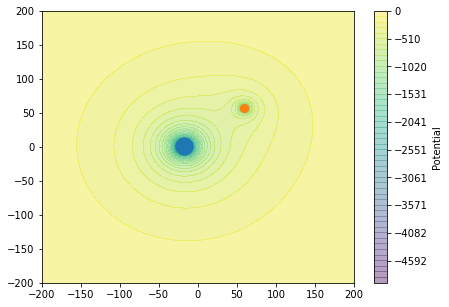

frame: 9/10


In [187]:
max_time=1000
_range = (-200,200)
density_of_mesh = 100
# masses
masses = np.array([10000,2000,5])
x0 = np.array([-20, 72])
y0 = np.array([0, 0])
vx0 = np.array([0, 0])
vy0 = np.array([0, 12])

# Calling the function to scale masses to determine its size.
scaled_masses = scale_the_array(masses) 

xx,yy = np.meshgrid(np.linspace(_range[0],_range[1],density_of_mesh), np.linspace(_range[0],_range[1], density_of_mesh))
coords = []
# this will work only if xx and yy have the same dims
for i in range(len(xx.ravel())):
    coords.append([xx.ravel()[i],yy.ravel()[i]])    
#coords = np.array(coords) # shape = (len(xx), 2)

for time in range(max_time):
    x1,y1,vx1,vy1 = step(masses, x0, y0, vx0, vy0, dt=0.5)
    plt.figure(figsize=(7,5))
    
    # Make a grid:
    # Measure the potential between each point of the grid and the star
    
    # for each coordinate in coords measure the R and find the potential:
    PE = []
    for coordinate in coords:
        # coordinate = [x_i, y_i]
        # for each mass calculate the R & potential:
        pe = 0
        for body in range(len(x1)):
            # calculate R:
            R = np.sqrt((x1[body]-coordinate[0])**2+(y1[body]-coordinate[1])**2)
            
            # Using the dummy mass (located at the end of the mass array)
            pe += -0.5*masses[body]*masses[-1]/R
        PE.append(pe)
    # reshape PE to be of the shape of xx and yy  
    PE = np.array(PE).reshape(xx.shape)
    #print(PE.max(),PE.min())
    
    plt.contourf(xx, yy, PE, cmap=plt.cm.viridis,levels=np.linspace(-50e2,0,50), alpha=0.4,vmin=-50e2,vmax=0)
    plt.colorbar(label='Potential')
    for i in range(len(x0)):
        plt.scatter(x1[i], y1[i], s= scaled_masses[i])
    plt.xlim(_range[0], _range[1])
    plt.ylim(_range[0], _range[1])
    #plt.savefig(f"../IAPT Course Work/Animations/{time+1}.png")

    plt.show()
    print(f"frame: {time}/{str(max_time)}")    
    clear_output(wait=True)
    x0 = x1
    y0 = y1
    vx0 = vx1
    vy0 = vy1